In [1]:
# If the below code doesn't work uncomment this and run (this adds the parent directory to the path)
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

import matplotlib.pyplot as plt
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np

dl = DataLib("SignalData")

In [204]:
'''
takes in indicator. Then processes return and plots bond return, indicator, and pnl
indicator is a function, returns new time series with the indicator

CURRENTLY ONLY DOING FOR USA
'''
bond_return_index = dl.pull('BondRetIdx/LocalFX')
bond_return_change = bond_return_index.resample('M').mean().pct_change()


def evaluate_performance(indicator):
    first_date = indicator.first_valid_index()
#     shifted_bond_return = bond_return_change.shift(-1)
    shifted_indicator = indicator.shift(1)
    days_profit = bond_return_change['USA'] * shifted_indicator
    days_profit += 1
    days_profit[first_date] = bond_return_index['USA'][first_date]
    pnl = days_profit.cumprod()
    return pnl
    
    
def plot_evaluation(indicator, pnl, plot_indicator = True):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(pnl.to_timestamp(), label = 'Portfolio Returns')
    ax1.plot(bond_return_index['USA'].to_timestamp(), label = 'Bond Market Index')
    ax1.set_ylabel('Returns Index')
    ax1.legend()
    if plot_indicator:
        ax2.plot(indicator.to_timestamp(), color = 'tab:red',label = 'Indicator')
        ax2.set_ylabel('Indicator')
        ax2.legend(loc = 'lower right')
    plt.title('USA portfolio performance vs bond market')
    plt.show()
    std_portfolio_pct_change = pnl.pct_change().std()
    std_market_pct_change = bond_return_index['USA'].resample('M').mean().pct_change().std()
    vol_adjusted_pnl = pnl * std_market_pct_change / std_portfolio_pct_change
    vol_adjusted_pnl.plot(label = 'vol adjusted portfolio returns')
    bond_return_index['USA'].plot(label = 'bond market returns')
    plt.legend()
    plt.ylabel('returns')
    plt.xlabel('date')
    plt.title('USA bond market returns index vs vol adjusted portfolio returns index')
    plt.show()

    

looked at gdp growth as indicator for bonds but the US was literally just constantly increasing so that doesnt seem to be a good indicator. I wanted an indicator for internal conditions in the country because i felt the curve height indicator was a good external conditions indicator so we gonna try monetary base and see if it gives a better indicator that gdp growth :P

country          AUS       CAN       FRA       DEU       ITA       JPN  \
date                                                                     
1980-01-01       NaN       NaN       NaN       NaN       NaN       NaN   
1980-01-02  0.038252 -0.007363 -0.038997 -0.015114  0.012078  0.000000   
1980-01-03  0.016629 -0.007427 -0.002419 -0.015178  0.033810 -0.000020   
1980-01-04 -0.021448  0.001152  0.021712  0.009083 -0.002404 -0.002711   
1980-01-07  0.019170  0.009921  0.006589  0.002439  0.014761 -0.001200   

country          ESP       CHE       USA       GBR  
date                                                
1980-01-01       NaN       NaN       NaN       NaN  
1980-01-02 -0.040620  0.000000 -0.018854 -0.013401  
1980-01-03  0.000723 -0.001479 -0.005614 -0.009219  
1980-01-04 -0.003695 -0.005794  0.012363  0.012642  
1980-01-07  0.000000 -0.007857  0.002813  0.004852  
country     AUS       DEU  CAN  ESP  FRA  ITA  JPN  CHE       GBR       USA
date                              

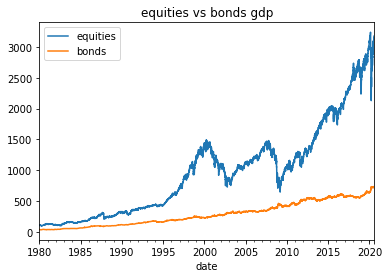

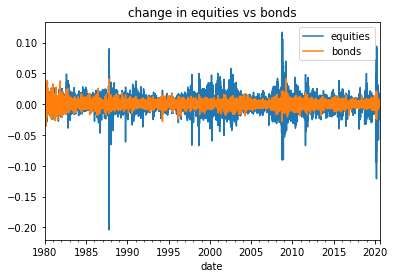

correlatioin:  -0.0643066914791318


In [9]:
curve_height_indicator = pd.Series([])
equity_prices = dl.pull('EquityPrices') #daily
change_in_equities = equity_prices.pct_change()
bond_return_index = dl.pull('BondRetIdx/LocalFX')
# change_in_bonds = bond_return_index.resample('M').mean().pct_change()
change_in_bonds = bond_return_index.pct_change()
print(change_in_equities.head())
print(change_in_bonds.head())

equity_prices['USA'].plot()
bond_return_index['USA'].plot()
plt.title('equities vs bonds gdp')
plt.legend(['equities', 'bonds'])
plt.show()

change_in_equities['USA'].plot()
change_in_bonds['USA'].plot()
plt.title('change in equities vs bonds')
plt.legend(['equities', 'bonds'])
plt.show()

print('correlation: ', change_in_bonds['USA'].corr(change_in_equities['USA']))


# gdp_nom.plot()
# plt.title('nom gdp around world')
# plt.show()

country  DEU       CAN  ESP       FRA       ITA       JPN  CHE  GBR       USA
date                                                                         
1980-01  NaN       NaN  NaN       NaN       NaN       NaN  NaN  NaN       NaN
1980-02  NaN  0.027795  NaN -0.009873 -0.004106 -0.035706  NaN  NaN  0.008026
1980-03  NaN -0.020369  NaN -0.066273 -0.060768  0.007787  NaN  NaN  0.003479
1980-04  NaN  0.016702  NaN  0.066250  0.079735  0.053850  NaN  NaN  0.001600
1980-05  NaN  0.028894  NaN  0.018842  0.022719  0.077458  NaN  NaN  0.006723
country  AUS       DEU  CAN  ESP  FRA  ITA  JPN  CHE       GBR       USA
date                                                                    
1980-01  NaN       NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN       NaN
1980-02  NaN -0.015638  NaN  NaN  NaN  NaN  NaN  NaN  0.011068 -0.077781
1980-03  NaN -0.056285  NaN  NaN  NaN  NaN  NaN  NaN  0.009164 -0.010159
1980-04  NaN  0.008272  NaN  NaN  NaN  NaN  NaN  NaN  0.048784  0.079100
1980-05  NaN  0.

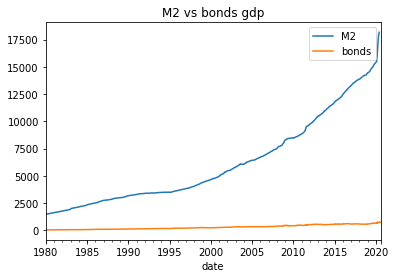

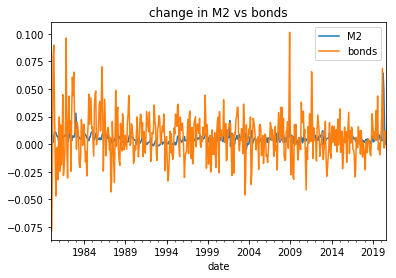

correlation:  0.12698813491300281


In [13]:
m1 = dl.pull('M1/inUSD') #monthly
m2 = dl.pull('M2/inUSD') 
m3 = dl.pull('M3/inUSD') 
change_in_m2 = m2.pct_change()
bond_return_index = dl.pull('BondRetIdx/LocalFX')
change_in_bonds = bond_return_index.resample('M').mean().pct_change()
# change_in_bonds = bond_return_index.pct_change()
print(change_in_m2.head())
print(change_in_bonds.head())

m2['USA'].plot()
bond_return_index['USA'].plot()
plt.title('M2 vs bonds gdp')
plt.legend(['M2', 'bonds'])
plt.show()

change_in_m2['USA'].plot()
change_in_bonds['USA'].plot()
plt.title('change in M2 vs bonds')
plt.legend(['M2', 'bonds'])
plt.show()

print('correlation: ', change_in_bonds['USA'].corr(change_in_m2['USA']))


from a very preliminary look, change in monetary base seems to be a better indicator than change in equities so I will continue looking into monetary basis as an indicator.

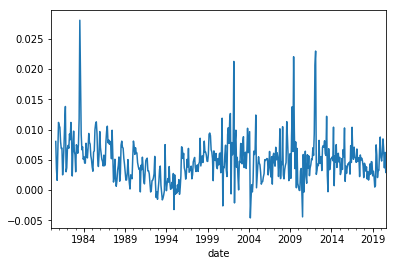

correlation:  -0.07459879902995842


In [36]:
rolling_change_m2 = change_in_m2.rolling(1).mean()
rolling_change_m2 = rolling_change_m2.shift(6)
rolling_change_m2['USA'].plot()
plt.show()
print('correlation: ', change_in_bonds['USA'].corr(rolling_change_m2['USA']))

In [18]:
change_in_m2.min()

country
DEU   -0.082494
CAN   -0.107777
ESP   -0.095006
FRA   -0.103834
ITA   -0.102505
JPN   -0.090743
CHE   -0.101671
GBR   -0.120316
USA   -0.004615
dtype: float64

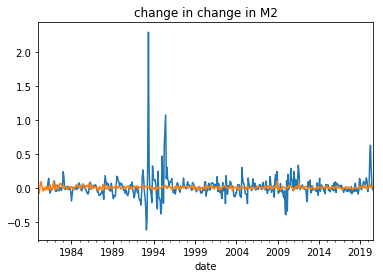

correlation:  0.07018887969280899


In [24]:
rolling_change_m2 = change_in_m2.rolling(12).mean()
change_change_in_m2 = rolling_change_m2.pct_change()
change_change_in_m2['USA'].plot()
change_in_bonds['USA'].plot()
plt.title('change in change in M2')
plt.show()
print('correlation: ', change_in_bonds['USA'].corr(change_change_in_m2['USA']))

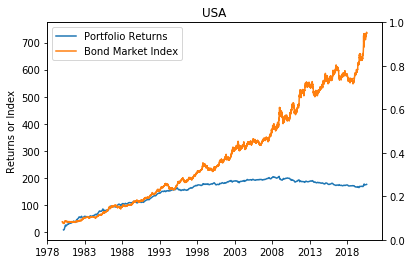

In [42]:
binary_m2_indicator = pd.Series([])
shifted_change_in_m2 = change_in_m2.shift(1)

for date in change_in_m2.index:
    binary_m2_indicator.loc[date] = -1 if shifted_change_in_m2['USA'][date] > change_in_m2['USA'][date] else 1
    
pnl = evaluate_performance(binary_m2_indicator)
plot_evaluation(binary_m2_indicator, pnl)

mean of 2 months


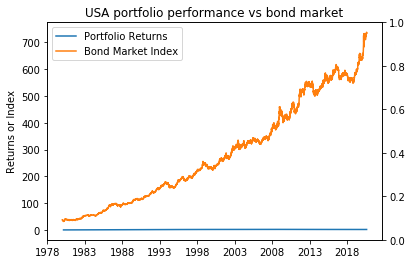

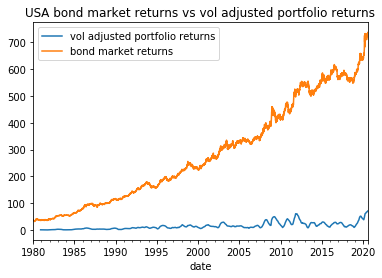

max return:  2.055792199244231
----------------------------------
mean of 3 months


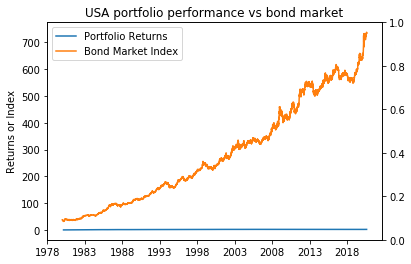

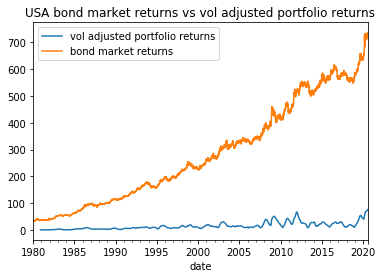

max return:  2.078056654421438
----------------------------------
mean of 4 months


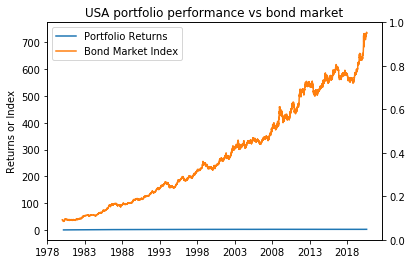

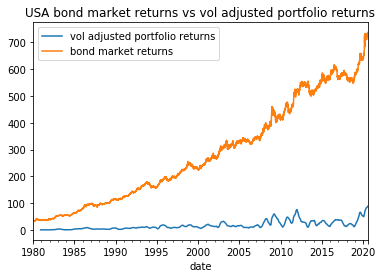

max return:  2.263939389130777
----------------------------------
mean of 5 months


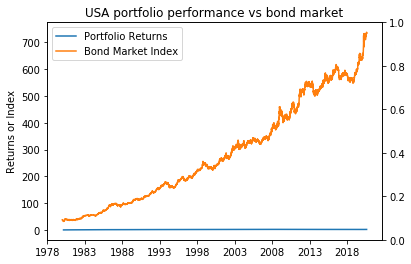

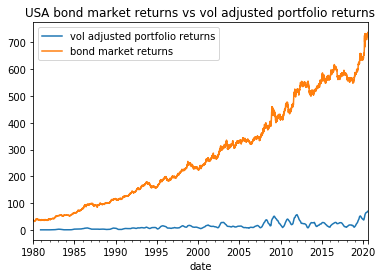

max return:  1.943462019506815
----------------------------------
mean of 6 months


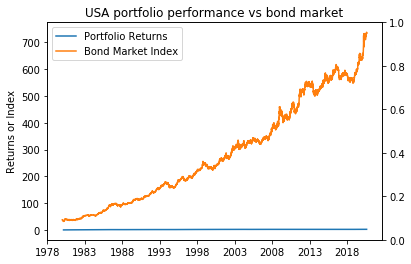

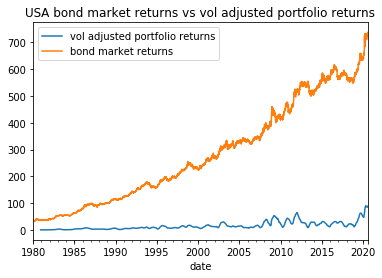

max return:  2.1804513252176045
----------------------------------
mean of 7 months


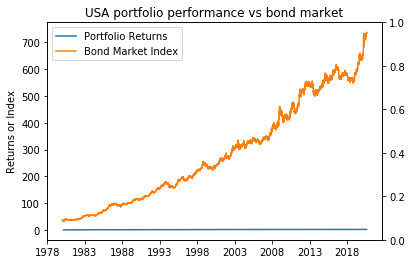

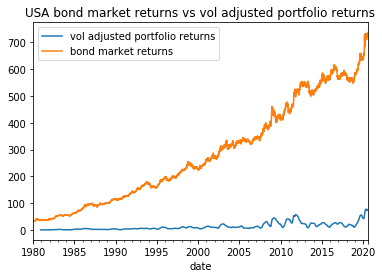

max return:  1.8869790568549432
----------------------------------
mean of 8 months


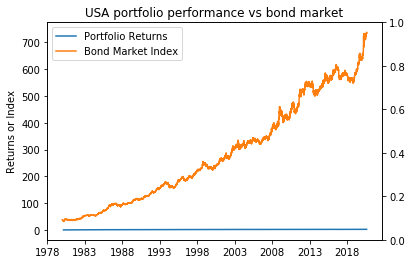

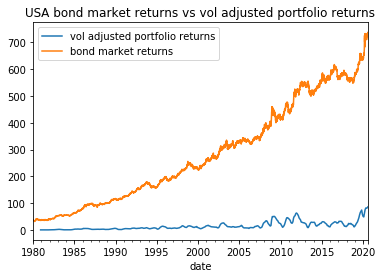

max return:  2.145087758753027
----------------------------------
mean of 9 months


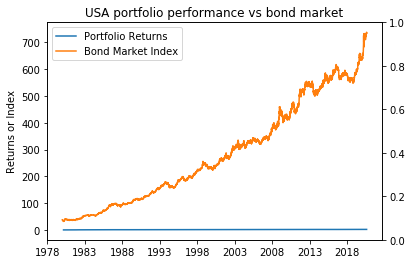

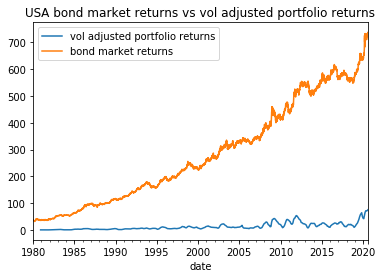

max return:  1.8727290179650695
----------------------------------


In [89]:
for i in range (2,10):
    print('mean of ' + str(i) + ' months')
    binary_m2_indicator = pd.Series([])
    averaged_change_in_m2 = change_in_m2.rolling(i).mean()

    for date in change_in_m2.index:
        binary_m2_indicator.loc[date] = -1 if averaged_change_in_m2['USA'][date] > change_in_m2['USA'][date] else 1

    pnl = evaluate_performance(binary_m2_indicator)
    plot_evaluation(binary_m2_indicator, pnl)
    print('max return: ', pnl.max())
    print('----------------------------------')

with a binary indicator, it appears dividing by a 4 month lag is the best. This is also better than just comparing to previous monetary trend. Now I need to look at not making the indicator binary and seeing what happens. However, as I saw with the US, I would imagine this would be specific to the USA

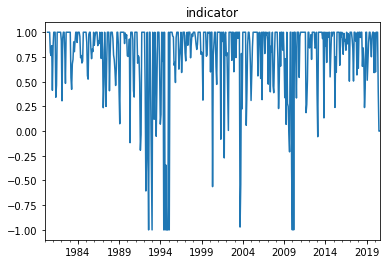

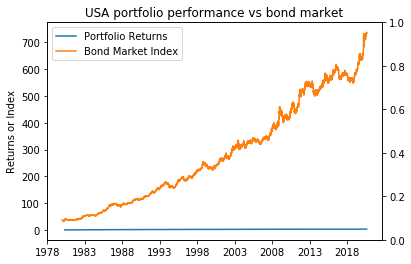

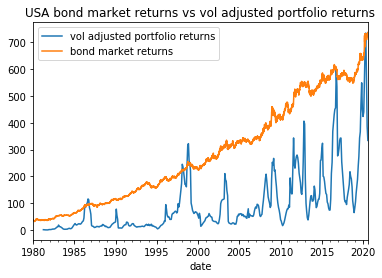

max return:  3.1214778588014456


In [90]:
binary_m2_indicator = pd.Series([])
averaged_change_in_m2 = change_in_m2.rolling(4).mean()

for date in change_in_m2.index:
    binary_m2_indicator.loc[date] = change_in_m2['USA'][date] / averaged_change_in_m2['USA'][date]

binary_m2_indicator = binary_m2_indicator.clip(-1,1)
binary_m2_indicator.plot()
plt.title('indicator')
plt.show()
pnl = evaluate_performance(binary_m2_indicator)
plot_evaluation(binary_m2_indicator, pnl)
print('max return: ', pnl.max())

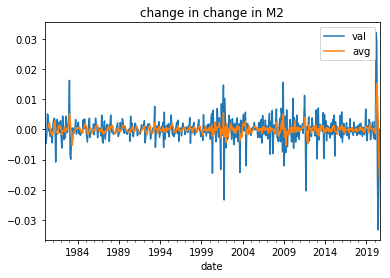

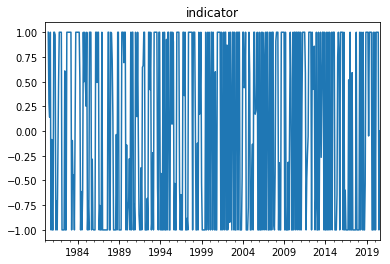

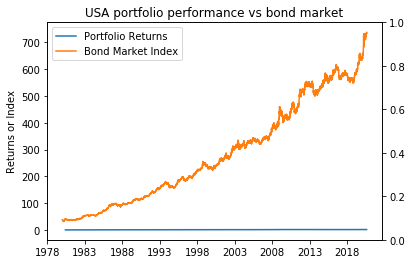

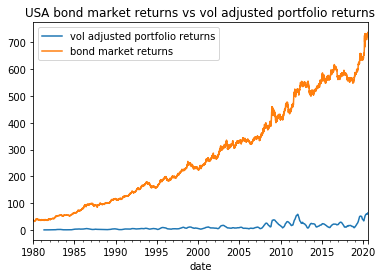

max return:  1.5009838690365926


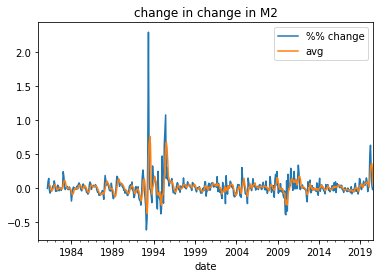

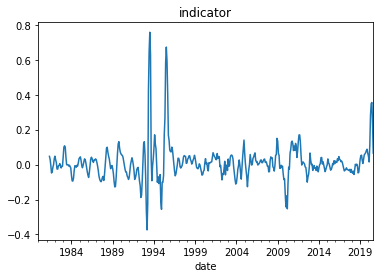

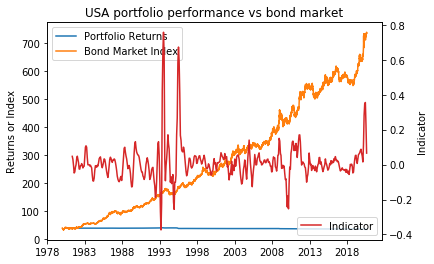

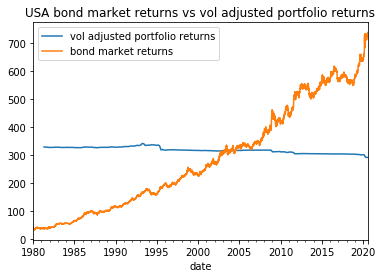

max return:  39.466369988186905


In [108]:
binary_m2_indicator = pd.Series([])
change_change_m2 = change_in_m2.pct_change()
averaged_change_change_in_m2 = change_change_m2.rolling(4).mean()
binary_m2_indicator = averaged_change_change_in_m2['USA']
# binary_m2_indicator = change_change_m2['USA'] / averaged_change_change_in_m2['USA']

change_change_m2['USA'].plot(label = '%% change')
averaged_change_change_in_m2['USA'].plot(label = 'avg')
plt.legend()
plt.title('change in change in M2')
plt.show()

binary_m2_indicator = binary_m2_indicator.clip(-1,1)
binary_m2_indicator.plot()
plt.title('indicator')
plt.show()
pnl = evaluate_performance(binary_m2_indicator)
plot_evaluation(binary_m2_indicator, pnl)
print('max return: ', pnl.max())

In [66]:
std_portfolio = binary_m2_indicator.std()
std_market = bond_return_index.std()
print(std_portfolio)
print(std_market)

0.5074570872667877
country
AUS    411.464692
DEU    190.959093
CAN    267.590261
ESP    345.524625
FRA    242.829165
ITA    316.079585
JPN     81.113687
CHE    111.069492
GBR    299.045891
USA    188.963431
dtype: float64


maybe combine this with CPI since this is mostly an indicator for inflation and could have it where when both are increasing very strong indicator to long and when signals are mixed maybe keep it more around 0 due to uncertainty

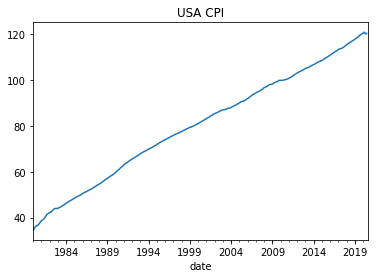

In [80]:
cpi = dl.pull('CoreCPI/SA')
cpi['USA'].plot()
plt.title('USA CPI')
plt.show()

CPI is consistently going up so i dont think it would add much to the indicator if I tested to go lon gonly if it was increasing. The increase if also very consistent so I do not think it would give much new information

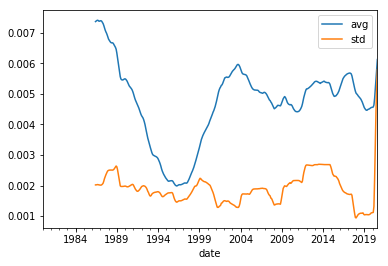

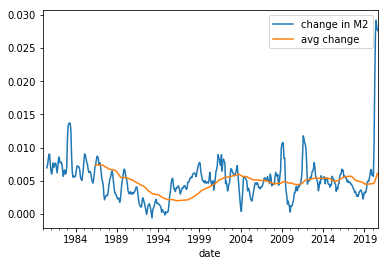

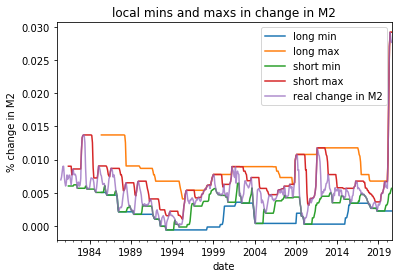

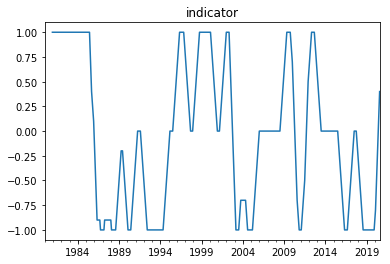

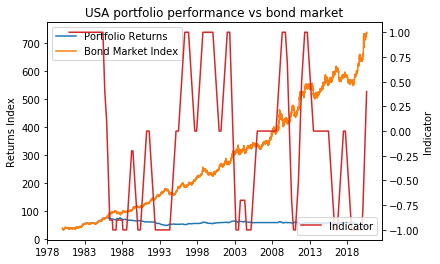

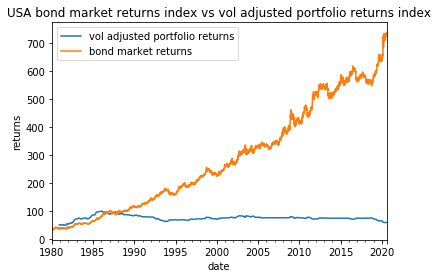

max return:  76.08424458368297


In [206]:
# m2_indicator = pd.Series([])
mins_and_maxs = pd.Series([])
change_in_m2 = m2.pct_change() #monthly
change_in_m2 = change_in_m2.rolling(6).mean()
country = 'USA'



# # STD Z-Score way to caluclate
avg_change_in_m2 = change_in_m2.rolling(12 * 6).mean()
std_change_in_m2 = change_in_m2.rolling(12 * 6).std()
avg_change_in_m2[country].plot(label = 'avg')
std_change_in_m2[country].plot(label = 'std')
plt.legend()
plt.show()

   
change_in_m2[country].plot(label = 'change in M2')
avg_change_in_m2[country].plot(label = 'avg change')
plt.legend()
plt.show()
    
# for date in change_in_m2.index:
#     m2_indicator.loc[date] = 1 if change_in_m2[country][date] > avg_change_in_m2[country][date] else -1
    
    
# Find local peaks
mins_and_maxs['long_local_min'] = change_in_m2[country].rolling(12*5).min()#change_in_m2[country][(change_in_m2[country].shift(12*3) > change_in_m2[country]) & (change_in_m2[country].shift(-12*3) > change_in_m2[country])]
mins_and_maxs['short_local_min'] = change_in_m2[country].rolling(12).min()
mins_and_maxs['long_local_max'] = change_in_m2[country].rolling(12*5).max()#change_in_m2[country][(change_in_m2[country].shift(12*3) < change_in_m2[country]) & (change_in_m2[country].shift(-12*3) < change_in_m2[country])]
mins_and_maxs['short_local_max'] = change_in_m2[country].rolling(12).max()

mins_and_maxs['long_local_min'].plot(label = 'long min')
mins_and_maxs['long_local_max'].plot(label = 'long max')
mins_and_maxs['short_local_min'].plot(label = 'short min')
mins_and_maxs['short_local_max'].plot(label = 'short max')
change_in_m2[country].plot(label = 'real change in M2', alpha = 0.75)
plt.title('local mins and maxs in change in M2')
plt.ylabel('% change in M2')
plt.xlabel('date')
plt.legend()
plt.show()

for date in change_in_m2.index:
    val = 0.05 if mins_and_maxs['short_local_min'][date] == mins_and_maxs['long_local_min'][date] else -0.05
    val += 0.05 if mins_and_maxs['short_local_max'][date] < mins_and_maxs['long_local_max'][date] else -0.05
    m2_indicator.loc[date] = val

# m2_indicator = -(change_in_m2[country] - avg_change_in_m2[country]) / std_change_in_m2[country]
    
m2_indicator = m2_indicator.rolling(12).sum()
# m2_indicator = m2_indicator.rolling(8).mean() 
m2_indicator = -m2_indicator.clip(-1,1)

m2_indicator.plot()
plt.title('indicator')
plt.show()

pnl = evaluate_performance(m2_indicator)
plot_evaluation(m2_indicator, pnl)
print('max return: ', pnl.max())


In [201]:
print(pnl['1990'])
print(m2_indicator['1990'])
shifted_bond_return = bond_return_change.shift(-1)
print(shifted_bond_return['USA']['1990'])
temp = bond_return_index.resample('M').mean()
print(temp['USA']['1990'])
# print(temp['USA']['1990'].shift(1))
# print(pnl['2015'])

date
1990-01    57.008520
1990-02    57.994526
1990-03    58.768467
1990-04    58.847794
1990-05    59.148300
1990-06    58.719553
1990-07    57.415773
1990-08    57.073075
1990-09    57.535011
1990-10    57.606027
1990-11    57.079287
1990-12    56.459775
Freq: M, dtype: float64
1990-01   -0.9
1990-02   -1.0
1990-03   -1.0
1990-04   -1.0
1990-05   -1.0
1990-06   -1.0
1990-07   -0.9
1990-08   -0.8
1990-09   -0.7
1990-10   -0.6
1990-11   -0.5
1990-12   -0.4
Freq: M, dtype: float64
date
1990-01   -0.013345
1990-02   -0.001350
1990-03   -0.005107
1990-04    0.007249
1990-05    0.024671
1990-06    0.007461
1990-07   -0.011563
1990-08   -0.002057
1990-09    0.018288
1990-10    0.027134
1990-11    0.025750
1990-12    0.006201
Freq: M, Name: USA, dtype: float64
date
1990-01    114.762261
1990-02    113.230750
1990-03    113.077909
1990-04    112.500476
1990-05    113.315957
1990-06    116.111524
1990-07    116.977818
1990-08    115.625261
1990-09    115.387400
1990-10    117.497565
1990-11   

In [113]:
bond_return_index = dl.pull('BondRetIdx/LocalFX')
bond_return_change = bond_return_index.resample('M').mean().pct_change()


def evaluate_performance_GBR(indicator):
    first_date = indicator.first_valid_index()
    shifted_bond_return = bond_return_change.shift(1)
    days_profit = -shifted_bond_return['GBR'] * indicator
    days_profit += 1
    days_profit[first_date] = bond_return_index['GBR'][first_date]
    pnl = days_profit.cumprod()
    return pnl
    
    
def plot_evaluation_GBR(indicator, pnl, plot_indicator = True):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(pnl.to_timestamp(), label = 'Portfolio Returns')
    ax1.plot(bond_return_index['GBR'].to_timestamp(), label = 'Bond Market Index')
    ax1.set_ylabel('Returns or Index')
    ax1.legend()
    if plot_indicator:
        ax2.plot(indicator.to_timestamp(), color = 'tab:red',label = 'Indicator')
        ax2.set_ylabel('Indicator')
        ax2.legend(loc = 'lower right')
    plt.title('GBR portfolio performance vs bond market')
    plt.show()
    std_portfolio_pct_change = pnl.pct_change().std()
    std_market_pct_change = bond_return_index['GBR'].resample('M').mean().pct_change().std()
    vol_adjusted_pnl = pnl * std_market_pct_change / std_portfolio_pct_change
    vol_adjusted_pnl.plot(label = 'vol adjusted portfolio returns')
    bond_return_index['GBR'].plot(label = 'bond market returns')
    plt.legend()
    plt.title('GBR bond market returns vs vol adjusted portfolio returns')
    plt.show()

    

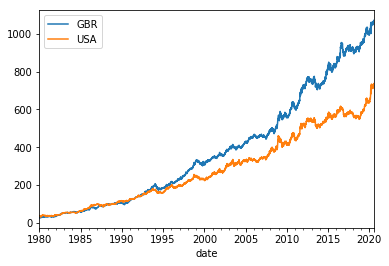

In [115]:
bond_return_index['GBR'].plot(label = 'GBR')
bond_return_index['USA'].plot(label = 'USA')
plt.legend()
plt.show()

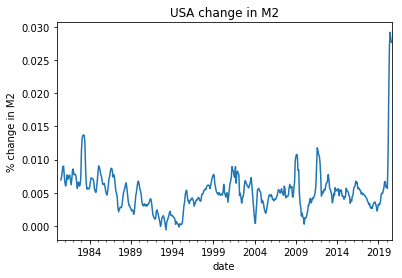

In [176]:
change_in_m2['USA'].plot()
plt.title('USA change in M2')
plt.ylabel('% change in M2')
plt.xlabel('date')
plt.show()